In [72]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [73]:
data = pd.read_csv("./dataset.csv", header=0)

MISSING_VALUE = 999.99

complete_df = data
complete_df = complete_df[~complete_df.isin([MISSING_VALUE]).any(axis=1)]

incomplete_df = data
incomplete_df = incomplete_df[incomplete_df.isin([MISSING_VALUE]).any(axis=1)]

### Boxplots de cada variable

Text(0.5, 1.0, 'Grasas_sat')

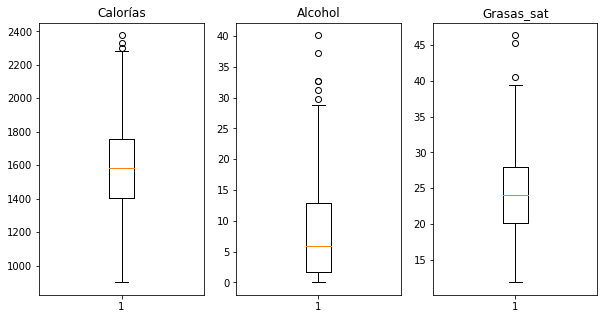

In [74]:

# Plot de data sin escalar
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
axes[0].boxplot(complete_df["Calorías"])
axes[0].set_title("Calorías")

axes[1].boxplot(complete_df["Alcohol"])
axes[1].set_title("Alcohol")

axes[2].boxplot(complete_df["Grasas_sat"])
axes[2].set_title("Grasas_sat")

### Comparación de datos sin estandarizar vs estandarizados mediante boxplots

Text(0.5, 1.0, 'Boxplot de datos estandarizados')

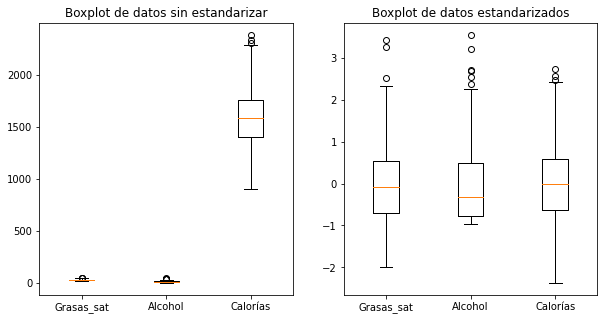

In [75]:
# Plot de data sin escalar
data_without_genre = complete_df.drop("Sexo", axis=1)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].boxplot(data_without_genre)
axes[0].set_xticks([1, 2, 3], data_without_genre.columns)
axes[0].set_title("Boxplot de datos sin estandarizar")


scaler = StandardScaler().fit(data_without_genre)
scaled_data = scaler.transform(data_without_genre)
# Plot de data escalada
axes[1].boxplot(pd.DataFrame(scaled_data))
axes[1].set_xticks([1, 2, 3], data_without_genre.columns)
axes[1].set_title("Boxplot de datos estandarizados")

### Reemplazo de datos faltantes